# Machine Learning Lab - Learning Unit 3
## Domain Translation between T1- and T2-weighted Magnetic Resonance Images using U-Net

Magnetic resonance imaging makes it possible to generate images of the same tissue with different grey scale values. With T1 weighting, fatty body tissue and structures are displayed with a higher intensity than the surrounding tissue, while with T2 weighting, fluid-filled body structures are displayed with hyperintensity. Depending on the examination, one or the other weighting can be useful; often only their combination provides the full range of required information.

In this notebook we want to train a U-Net that receives **T1-weighted brain scans as input** and **generates the corresponding T2-weighted images as output**. Corresponding image pairs are given for training and testing. To load the data, we provide you with the `BrainsDataset` class (see below). With the parameter `mode` you can switch between training and test data. `mode=train` will load the training data and `mode=test` the test data. Default value is `train`.

The U-Net is the most commonly used convolutional network architecture for image processing tasks. The original paper can be found here: https://arxiv.org/abs/1505.04597. Further interesting reads are:


*   https://paperswithcode.com/method/u-net
*   https://medium.datadriveninvestor.com/an-overview-on-u-net-architecture-d6caabf7caa4
  



In [ ]:
#imports
import warnings
warnings.filterwarnings("ignore")
from torchmetrics.functional.image import structural_similarity_index_measure
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
import torch.nn as nn
import torch

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
from tqdm import tqdm_notebook as tqdm

import requests
import sys
import os
import glob
import skimage.io as io
from imageio import imread
from io import BytesIO
from zipfile import ZipFile

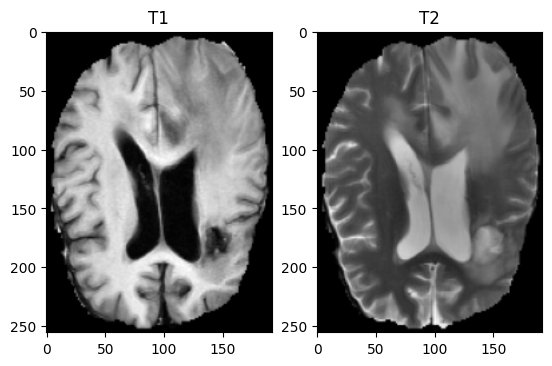

In [ ]:
class BrainsDataset(Dataset):
    ''' T1-T2 image pairs dataset '''

    def __init__(self, mode="train"):

        self.t1_images = []
        self.t2_images = []

        # Load data from cloud
        url = 'https://cloud.imi.uni-luebeck.de/s/2MdmDjnbfRFcP3g/download?path=/&files=' + mode + '.zip'
        r = requests.get(url)
        z = ZipFile(BytesIO(r.content))

        t1_list = [name for name in z.namelist() if mode + '/t1' in name]
        t2_list = []

        for t1_name in t1_list:
            t2_name = t1_name.replace('/t1', '/t2').replace('_t1', '_t2')

            if t2_name in z.namelist():
                t1_image = imread(z.open(t1_name))
                t2_image = imread(z.open(t2_name))
                self.t1_images.append(t1_image)
                self.t2_images.append(t2_image)
                t2_list.append(t2_name)
            else:
                continue

        self.t2_list = t2_list

    def __len__(self):
        return len(self.t2_list)

    def __getitem__(self, index):
        image_t1 = self.t1_images[index]/255.
        image_t2 = self.t2_images[index]/255.

        image_t1 = torch.tensor(image_t1).float()
        image_t2 = torch.tensor(image_t2).float()

        image_t1 = F.interpolate(image_t1.unsqueeze(0).unsqueeze(0), (256, 192), mode='bilinear').squeeze(0)
        image_t2 = F.interpolate(image_t2.unsqueeze(0).unsqueeze(0), (256, 192), mode='bilinear').squeeze(0)
        return {"t1":image_t1 , "t2":image_t2}

# Initialize dataset
dataset = BrainsDataset()

# Plot T1- and T2-weighted images for one patient
fig, ax = plt.subplots(1, 2)
ax[0].imshow(dataset.__getitem__(46)['t1'].numpy()[0,:], cmap='gray')
ax[0].title.set_text('T1')
ax[1].imshow(dataset.__getitem__(46)['t2'].numpy()[0,:], cmap='gray');
ax[1].title.set_text('T2')

## Task 1
Complete the **2D U-Net**.  The architecture used should correspond to the following:



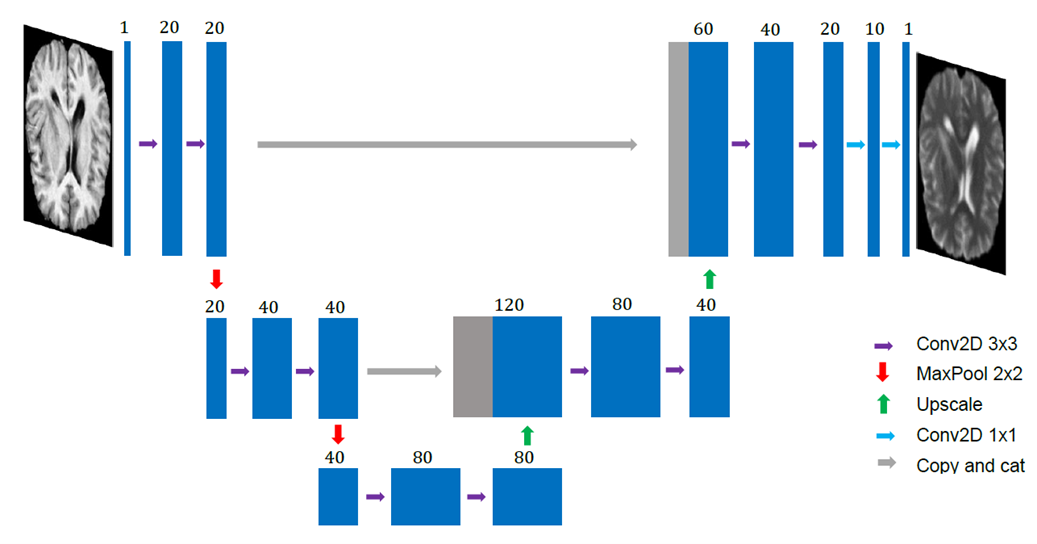

The numbers above the blue boxes indicate the number of feature maps. Red arrows signify maximum pooling with kernel size 2x2 and stride 2. For convolutional layers with kernel size 3x3 use `padding=1`. Each 3x3-convolution should be followed by batch normalization and ReLU activation. For upscaling you can try different interpolation methods (nearest, bilinear). Gray arrows stand for skip connections, the decisive difference of U-Net compared to other CNN architectures.

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)

        #Downsampling
        self.block0 = nn.Sequential(
          nn.Conv2d(in_channels = 1, out_channels = 20, kernel_size = 3, padding = 1),
          nn.BatchNorm2d(num_features = 20),
          nn.ReLU(),

          nn.Conv2d(in_channels = 20, out_channels = 20, kernel_size = 3, padding = 1),
          nn.BatchNorm2d(num_features = 20),
          nn.ReLU()
        )
        self.block1 = nn.Sequential(
          nn.Conv2d(in_channels = 20, out_channels = 40, kernel_size = 3, padding = 1),
          nn.BatchNorm2d(num_features = 40),
          nn.ReLU(),

          nn.Conv2d(in_channels = 40, out_channels = 40, kernel_size = 3, padding = 1),
          nn.BatchNorm2d(num_features = 40),
          nn.ReLU()
        )
        #Bottleneck
        self.bottleneck = nn.Sequential(
          nn.Conv2d(in_channels = 40, out_channels = 80, kernel_size = 3, padding = 1),
          nn.BatchNorm2d(num_features =80),
          nn.ReLU(),

          nn.Conv2d(in_channels = 80, out_channels = 80, kernel_size = 3, padding = 1),
          nn.BatchNorm2d(num_features = 80),
          nn.ReLU()
        )

        #Upsampling
        self.block3 = nn.Sequential(
          nn.Conv2d(in_channels = 120, out_channels = 80, kernel_size = 3, padding = 1),
          nn.BatchNorm2d(num_features = 80),
          nn.ReLU(),

          nn.Conv2d(in_channels = 80, out_channels = 40, kernel_size = 3, padding = 1),
          nn.BatchNorm2d(num_features = 40),
          nn.ReLU()
        )
        self.block4 = nn.Sequential(
          nn.Conv2d(in_channels = 60, out_channels = 40, kernel_size = 3, padding = 1),
          nn.BatchNorm2d(num_features = 40),
          nn.ReLU(),

          nn.Conv2d(in_channels = 40, out_channels = 20, kernel_size = 3, padding = 1),
          nn.BatchNorm2d(num_features = 20),
          nn.ReLU()
        )
        #Final Convolution
        self.final_conv = nn.Sequential(
            nn.Conv2d(in_channels = 20, out_channels = 10, kernel_size = 1),
            nn.Conv2d(in_channels = 10, out_channels = 1, kernel_size = 1)
        )

        self.downs.append(self.block0)
        self.downs.append(self.block1)
        self.ups.append(self.block3)
        self.ups.append(self.block4)

    def forward(self, x):
      #Defining a list for the skip connections
      skip_connections = []

      #Iterating over the self.down blocks
      for down in self.downs:
        x = down(x)
        skip_connections.append(x)
        x = self.pool(x)

      #Processing through the bottleneck layer
      x = self.bottleneck(x)

      #Turning the skip_connections-list around
      skip_connections = skip_connections[::-1]

      #Iterating over the self.up layers
      for idx in range(0, len(self.ups)):

        #Getting the skip_connection to merge with
        skip_connection = skip_connections[idx]

        #Interpolating of x with scale-factor 2 (Upscale)
        x = F.interpolate(x, scale_factor = 2, mode = 'bilinear', align_corners = True)

        #Concatinating
        concat_skip = torch.concat((skip_connection, x), dim = 1)

        #Double Conv
        x = self.ups[idx](concat_skip)

      output = self.final_conv(x)
      return output

    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()


In [ ]:
# Helper function for visualization of results during training
def visualize_images(axs, source, target, result, is_training, epoch, every_epoch):
    """Imshow first sample of batch"""
    offset = 0
    phase = 'training'
    if not is_training:
        phase = 'validation'
        offset = 3

    source = source[0, 0, ...].cpu()
    target=target[0,0,...].cpu()
    preds = (result.detach()[0, 0, ...].cpu()).float()

    axs[epoch//every_epoch][0 + offset].imshow(source, cmap='gray')
    axs[epoch//every_epoch][0 + offset].set_title(str(epoch) + ': ' + phase + ' source')
    axs[epoch//every_epoch][0 + offset].grid(False)
    axs[epoch//every_epoch][1 + offset].imshow(target, cmap='gray')
    axs[epoch//every_epoch][1 + offset].set_title(str(epoch) + ': ' + phase + ' target')
    axs[epoch//every_epoch][1 + offset].grid(False)
    axs[epoch//every_epoch][2 + offset].imshow(preds, cmap='gray')
    axs[epoch//every_epoch][2 + offset].set_title(str(epoch) + ': ' + phase + ' prediction')
    axs[epoch//every_epoch][2 + offset].grid(False)
    return axs

## Task 2
Implement the training of the U-Net. As loss function use a **suitable image distance measure** to compare real and generated T2-weighted images.

In [ ]:
batch_size = 20

n_epochs = 101
every_epoch = n_epochs//10

device = 'cuda' if torch.cuda.is_available() else 'cpu'

fig, axs = plt.subplots(n_epochs//every_epoch + 1, 6, sharex=True, sharey=True,
                        figsize=(5*5, 7*n_epochs//every_epoch))

dataset_training = BrainsDataset()

# Split training dataset into 80% training images and 20% validation images
indices = list(range(len(dataset_training)))
split_index = int(len(dataset_training) * 0.8)
sampler_training = SubsetRandomSampler(indices[:split_index])
sampler_validate = SubsetRandomSampler(indices[split_index:])

loader_training = DataLoader(dataset=dataset_training,
                             batch_size=batch_size,
                             sampler=sampler_training,
                             drop_last=True)

loader_validate = DataLoader(dataset=dataset_training,
                             batch_size=batch_size,
                             sampler=sampler_validate,
                             drop_last=True)

# Initialize U-Net
unet = UNet().to(device)
unet.weight_init(mean=0.0, std=0.02)

def loss_fn(input, target):
  ssim_value = structural_similarity_index_measure(input, target)
  return 1 - ssim_value

optimizer = torch.optim.Adam(unet.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=(9*n_epochs)//10, gamma=0.1)

losses_training = []
losses_validate = []

for epoch in range(n_epochs):

    # Scheduler will adapt the learning rate once the step count reaches threshold
    scheduler.step()

    ########################################
    #               TRAINING               #
    ########################################

    sum_loss = 0

    # Parameters must be trainable
    unet.train(True)
    with torch.set_grad_enabled(True):

        for batch in loader_training:
            source_image = batch['t1'].to(device)
            target_image = batch['t2'].to(device)

            # To do: Implement the training
            # predicted_image = ?  forward run
            predicted_image = unet.forward(source_image)

            # loss = ? compute loss
            loss = loss_fn(predicted_image, target_image)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            sum_loss += loss.item()

        losses_training.append(sum_loss / len(loader_training))

    if epoch % every_epoch == 0:
        axs = visualize_images(axs, source_image,target_image, predicted_image, True, epoch, every_epoch)


    ########################################
    #              VALIDATION              #
    ########################################

    sum_loss = 0

    # Parameters must not be trainable
    unet.train(False)
    with torch.set_grad_enabled(False):

        # main loop to process all validation samples (packed into batches)
        for batch in loader_validate:
            source_image = batch['t1'].to(device)
            target_image = batch['t2'].to(device)

            # To do: Implement the validation
            # forward run
            predicted_image = unet.forward(source_image)
            # loss
            loss = loss_fn(predicted_image, target_image)
            # No need to backpropagate here!

            sum_loss += loss.item()

        losses_validate.append(sum_loss / len(loader_validate))

    if epoch % every_epoch == 0:
        print('Epoch ' + str(epoch) + ' - Training Loss: ' + str(losses_training[-1]) +
              ', Validation Loss: ' + str(losses_validate[-1]))
        axs = visualize_images(axs, source_image,target_image, predicted_image, False, epoch, every_epoch)

print('\n')

Output hidden; open in https://colab.research.google.com to view.

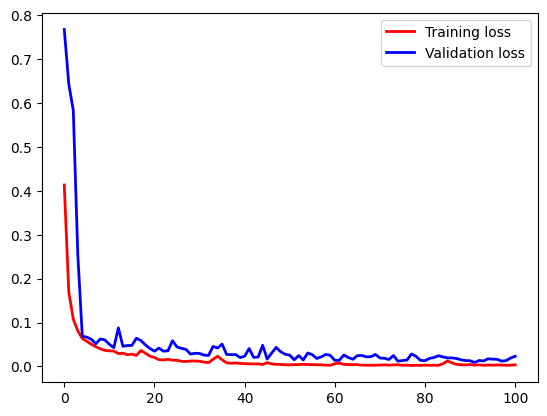

In [ ]:
# Plot training and validation loss
plt.figure()
plt.plot(losses_training, 'r-', linewidth=2)
plt.plot(losses_validate, 'b-', linewidth=2)
plt.legend(('Training loss', 'Validation loss'));

## Task 3
Now use the test data to get an unbiased estimation of your network's performance on unseen data.

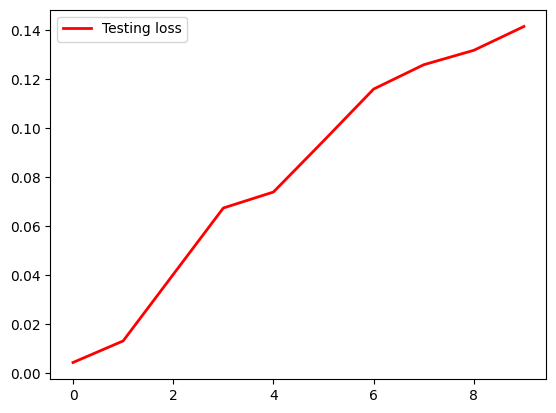

In [ ]:
dataset_testing = BrainsDataset(mode = 'test')

loader_testing = DataLoader(dataset = dataset_testing,
                            drop_last = True)

losses_testing = []
sum_loss = 0

with torch.no_grad():

  for image in loader_testing:

    unet.eval()
    source_image = image['t1'].to(device)
    target_image = image['t2'].to(device)

    prediction = unet.forward(source_image)
    loss = loss_fn(prediction, target_image)

    sum_loss += loss.item() #Exctracting a single element item from a pytorch tensor

    losses_testing.append(sum_loss/len(loader_testing))


plt.figure()
plt.plot(losses_testing, 'r-', linewidth = 2)
plt.legend(('Testing loss',))